Routines for making plots etc. after ev_fit has been run

In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
from PhD_Luminosity_function_final import *
from evfit import *
from simcat import *

In [24]:
def plot_res(infile='jswml_GII_sim_0.fits'):
    """Plot results from a single run of ev_fit."""

    dat = pickle.load(open(infile, 'rb'))
    zstep = dat['zbin'][1] - dat['zbin'][0]
    plt.clf()
    ax = plt.subplot(311)
    plt.cla()
    ax.step(dat['zbin'], dat['delta'], where='mid')
    ax.errorbar(dat['zbin'], dat['delta'], dat['delta_err'], fmt='none')
    ax.bar(dat['zbin'] - 0.5*zstep, 2*np.sqrt(dat['den_var']), 
           width=zstep, bottom=dat['delta'] - np.sqrt(dat['den_var']), 
           alpha=0.1, ec='none')
    ax.plot([dat['zbin'][0], dat['zbin'][-1]], [1.0, 1.0], ':')
    ax.set_ylim(0, 5)
    ax.set_xlabel('Redshift z')          
    ax.set_ylabel(r'$\Delta(z)$')
    ax.text(0.1, 0.9, r'$P = {:4.2f},\ Q = {:4.2f}$'.format(P, Q),
            transform = ax.transAxes)

    ax = plt.subplot(312)
    plt.cla()
    ax.errorbar(dat['Mbin'], dat['phi'], dat['phi_err'])
    ax.set_xlabel(r'$M_r$')
    ax.set_ylabel(r'$\Phi(M_r)$')
    ax.semilogy(base=10, nonpositive='clip')
    ax.set_ylim(1e-6, 0.05)
    plt.subplots_adjust(hspace=0.25)

    extent = (Pmin, Pmax, Qmin, Qmax)
    cmap = matplotlib.cm.jet
    ax = plt.subplot(313)
    im = ax.imshow(chi2grid, cmap=cmap, aspect='auto', origin='lower', 
                   extent=extent, interpolation='nearest')
    cb = plt.colorbar(im, ax=ax)
    (j, i) = np.unravel_index(np.argmin(chi2grid), chi2grid.shape)
    P_maxl = Pmin + (i+0.5)*Pstep
    Q_maxl = Qmin + (j+0.5)*Qstep
    ax.plot(P_maxl, Q_maxl, '+')
    ax.set_xlabel('P')
    ax.set_ylabel('Q')
    # Add contour at chi²_min + 4
    chi2_min = chi2grid.min()
    contour_level = chi2_min + 4
    ax.contour(Pa, Qa, chi2grid, levels=[contour_level], colors='white')
    plt.show()


KeyError: 'zmin'

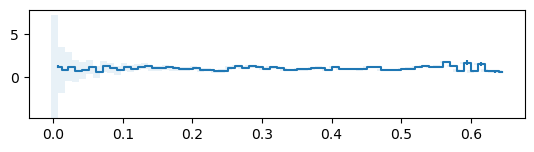

In [25]:
plot_res()

In [9]:
def sim_av(evroot='jswml_GII_sim_{}.fits', sims=[0,1,2,3,6,7],
        out_file='sim_table.tex'):
    """Average results from simulations."""

    nsim = len(sims)
    alpha = np.zeros(nsim)
    Mstar = np.zeros(nsim)
    lpstar = np.zeros(nsim)
    P = np.zeros(nsim)
    Q = np.zeros(nsim)
    delta = []
    delta_err = []
    den_var = []
    phi = []
    phi_err = []
    for i, isim in zip(range(nsim), sims):
        infile = evroot.format(isim)
        dat = pickle.load(open(infile, 'rb'))
        P[i] = dat['P']
        Q[i] = dat['Q']
        zbin = dat['zbin']
        delta.append(dat['delta'])
        delta_err.append(dat['delta_err'])
        den_var.append(dat['den_var'])
        alpha[i] = dat['alpha']
        Mstar[i] = dat['Mstar']
        lpstar[i] = dat['lpstar']
        Mbin = dat['Mbin']
        phi.append(dat['phi'])
        phi_err.append(dat['phi_err'])

    print('  alpha {:6.2f} +/- {:6.2f}'.format(np.mean(alpha), np.std(alpha)))
    print('     M* {:6.2f} +/- {:6.2f}'.format(np.mean(Mstar), np.std(Mstar)))
    print('lg phi* {:6.2f} +/- {:6.2f}'.format(np.mean(lpstar), np.std(lpstar)))
    print('      P {:6.2f} +/- {:6.2f}'.format(np.mean(P), np.std(P)))
    print('      Q {:6.2f} +/- {:6.2f}'.format(np.mean(Q), np.std(Q)))
    print('cov(Q,P) ', np.cov(Q, P))
    plt.clf()
    ax = plt.subplot(211)
    ax.errorbar(zbin, np.mean(delta, axis=0), np.std(delta, axis=0), fmt='none')
    ax.errorbar(zbin, np.mean(delta, axis=0), np.mean(delta_err, axis=0), fmt='none')
    dz = zbin[1] - zbin[0]
    den_sig = np.sqrt(np.mean(den_var, axis=0))
    ax.bar(zbin - 0.5*dz, 2*den_sig, width=dz, 
            bottom=np.mean(delta, axis=0)-den_sig, alpha=0.1, ec='none')
    ax.plot([zbin[0], zbin[-1]], [1.0, 1.0], ':')
    ax.set_xlabel('Redshift z')          
    ax.set_ylabel(r'$\Delta(z)$')
    ax.set_ylim(0.3, 1.7)
    ax = plt.subplot(212)
    ax.axis([dat['Mmin'], dat['Mmax'], 2e-7, 1])
    ax.semilogy(basey=10, nonposy='clip')
    ax.errorbar(Mbin, np.mean(phi, axis=0), np.std(phi, axis=0), fmt='none')
    ax.errorbar(Mbin, np.mean(phi, axis=0), np.mean(phi_err, axis=0), fmt='none')
    label = plot_label(dat['param'])[1]
    ax.set_xlabel(label)
    ax.set_ylabel(r'$\Phi(M) / h^3 {\rm Mpc}^{-3}$')
    plt.show()


In [16]:
def gridplot_av(filenames=('jswml_GII_sim_{}.fits',), sims=[0,1,2,3,6,7],
                label=('LF-redshift',)):
    """Average of multiple chi-squared grids."""
    nsim = len(sims)
    P = np.zeros(nsim)
    Q = np.zeros(nsim)
    plt.clf()
    nplot = len(filenames)
    for iplot in range(nplot):
        ax = plt.subplot(nplot+1, 1, iplot+1)
        first = True

        for i, isim in zip(range(nsim), sims):
            infile = filenames[iplot].format(isim)
            dat = pickle.load(open(infile, 'rb'))

            chi2grid = dat['chi2grid']
            if first:
                chi2av = chi2grid
                first = False
            else:
                chi2av += chi2grid

            Qmin = dat['Qbins'][0]
            Qmax = dat['Qbins'][1]
            nQ = dat['Qbins'][2]
            Qstep = float(Qmax - Qmin)/nQ
            Pmin = dat['Pbins'][0]
            Pmax = dat['Pbins'][1]
            nP = dat['Pbins'][2]
            Pstep = float(Pmax - Pmin)/nP
            (iq, ip) = np.unravel_index(np.argmin(chi2grid), chi2grid.shape)
            P[i] = Pmin + (ip+0.5)*Pstep
            Q[i] = Qmin + (iq+0.5)*Qstep

            extent = (Pmin, Pmax, Qmin, Qmax)
            chi2min = np.min(chi2grid)
            ax.contour(chi2grid, (chi2min+4, ), # colors=('k'),
                       origin='lower', extent=extent,
                       linewidths=0.2)

        chi2av /= nsim
        chi2min = np.min(chi2av)
        ax.contour(chi2av, (chi2min+4, ), colors=('k'),
                   origin='lower', extent=extent)
        ax.errorbar(P.mean(), Q.mean(), xerr=P.std(), yerr=Q.std())
        ax.text(0.7, 0.9, label[iplot], transform=ax.transAxes)
        ax.set_ylabel(r'$Q_e\ ({\rm mag})$')
        print('min chi^2 (P,Q) = ({} +- {}, {} +- {})'.format(
            P.mean(), P.std(), Q.mean(), Q.std()))
    ax.set_xlabel(r'$P_e$')
    plt.subplots_adjust(hspace=0.0)
    plt.show()


In [2]:
cd /Users/loveday/Data/gama/jswml_adrien

/Users/loveday/Data/gama/jswml_adrien


min chi^2 (P,Q) = (2.016666666666667 +- 0.3771236166328254, 0.5833333333333334 +- 0.19454362549881252)


/var/folders/jc/c3mhzns92bs5g27hq991w1g40000gp/T/ipykernel_34238/349379695.py:44: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax.contour(chi2av, (chi2min+4, ), colors=('k'),


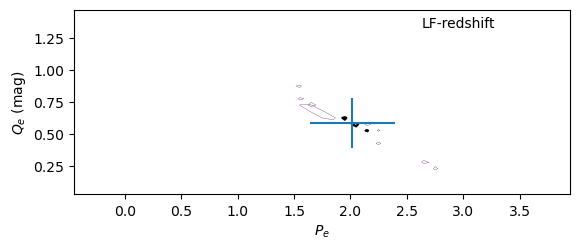

In [17]:
gridplot_av()

In [13]:
pdb.pm()


> /var/folders/jc/c3mhzns92bs5g27hq991w1g40000gp/T/ipykernel_34238/4203171006.py(14)gridplot_av()
     12 
     13         for i, isim in zip(range(nsim), sims):
---> 14             infile = filenames[iplot].format(sims[isim])
     15             dat = pickle.load(open(infile, 'rb'))
     16 

0
6
('jswml_GII_sim_{}.fits',)
'jswml_GII_sim_{}.fits'
